In [16]:
# %pip install pandas duckdb matplotlib seaborn

import pandas as pd
# import duckdb
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.ticker as ticker

In [17]:
plt.rcParams.update({'text.usetex': True
                            , 'pgf.rcfonts': False
                            , 'text.latex.preamble': r"""\usepackage{iftex}
                                            \ifxetex
                                                \usepackage[libertine]{newtxmath}
                                                \usepackage[tt=false]{libertine}
                                                \setmonofont[StylisticSet=3]{inconsolata}
                                            \else
                                                \RequirePackage[tt=false, type1=true]{libertine}
                                            \fi"""
                         })

In [18]:
# Intersting attributes
# 'name'
# 'Product Collection'
# 'Code Name'
# 'Total Cores'
# 'Total Threads'
# 'Processor Base Frequency'
# 'Max Turbo Frequency'
# 'Vertical Segment' [Workstation,Desktop,Server]

key_vert_seg = 'Vertical Segment'
key_name = 'name'
key_collection = 'Product Collection'
key_code_name = 'Code Name'
key_core_count = 'Total Cores'
key_base_freq = 'Processor Base Frequency'
key_turbo_freq = 'Max Turbo Frequency'
key_launch_year = "Launch Year"
key_launch_date = "Launch Date"
key_launch_year_month = "Launch Year Month"
key_tdp = "TDP"
key_tdp_per_core = "TDP per Core"
key_perf_id = "performance_id"
key_max_memory_channels = 'Max # of Memory Channels'
key_memory_types = 'Memory Types'
key_max_transfer_rate = 'Memory Speed'
key_bandwidth = 'Bandwidth'
key_pcie_revision = 'PCI Express Revision'
key_max_pcie_lanes = 'Max # of PCI Express Lanes'
key_pcie_transfer_rate = 'PCIe Transfer Rate'
key_pcie_bandwidth = 'PCIe Bandwidth'

colors_single = '#d95f02'
colors_qualitative = ['#abd9e9', '#fdae61', '#d7191c']
colors_sequential = ['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026']

In [19]:
def extract_performance_id(name):
    match = re.search(r'\d{4}', name)
    if match:
        return match.group(0)[-2:]
    return None

In [20]:
file_path = '../intel_cpus.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path, sep=";")
else:
    raise FileNotFoundError(f"The file {file_path} does not exist.")

df[key_launch_year] = df[key_launch_date].str.split("-").str[0].astype(int)
df[key_launch_year_month] = df[key_launch_date].str.slice(0, 7)
df[key_base_freq] = df[key_base_freq]/10**9
df[key_turbo_freq] = df[key_turbo_freq]/10**9
df[key_tdp_per_core] = df[key_tdp] / df[key_core_count]

# con = duckdb.connect("../spec.db") # assumes DuckDB DB "spec.db" in root dir
# con.sql("DROP TABLE IF EXISTS intel_cpus")
# con.sql("CREATE TABLE intel_cpus AS SELECT * FROM df")
# con.close()
# Only consider server segment
df = df[df[key_vert_seg] == "Server"]
df[key_collection] = df[key_collection].str.replace('Generation', 'Gen')
df['performance_id'] = df['name'].apply(extract_performance_id)

# Drop data
# W Processors: cpus for workstations and small servers
# E Processors: entry-level servers and workstation microprocessors, https://en.wikichip.org/wiki/intel/xeon_e
# D Processors: Targeting the low-end server market, the Xeon D family puts priority on efficiency and networking - areas where dense, lower-power, lightweight hyperscale workloads are expected.
# see https://en.wikichip.org/wiki/intel/xeon_d
drop_collections = ["Legacy Xeon Processors", "Xeon W Processor", "Xeon E Processor", "Xeon D Processor", "Xeon CPU Max Series", "Xeon 6"]
df = df[~df[key_collection].isin(drop_collections)]
# E3: Workstation CPUs, https://www.cpu-world.com/info/id_model/Intel-server-conventions.html
# Drop rows where 'key_collection' contains "E3"
df = df[~df[key_collection].str.contains("E3")]
df.reset_index(inplace=True, drop=True)

# df[key_collection] = df[key_collection].str.replace("Processor", "Proc'")

# Max # of PCI Express Lanes
# PCI Express Revision

df[key_max_transfer_rate] = df[key_memory_types]

repl = lambda m: m.groups()[-1]
patterns = [
    r'^DDR[3|4|5][-| ](\d+)$',
    r'^DDR[3|4] (?:\d+/){1,4}(\d+)$',
    r'^DDR3 (?:\d+/){3}\d+ \(Max Speed (\d+) MHz\)$',
    r'^DDR5 @ (\d+) MT/s \(1 DPC(?: &2DPC)?\)$',
    r'^Up to DDR5 (\d+) MT/s 1DPC$',
    r'^Up to DDR5 (\d+) MT/s \(1DPC & 2DPC\)$',
    r'^Up to DDR5 (\d+) MT/s 1DPC and 2DPC$',
    r'^Up to DDR5 (\d+) MT/s 1DPC Up to DDR5 (?:\d+) MT/s 2DPC$', # Capture 1DPC
    r'^"?DDR4-1(?:\d+/){1,4}(\d+),? DDR3-(?:\d+/?){1,4}"?$' # Capture DDR4
]
for pattern in patterns:
    df[key_max_transfer_rate] = df[key_max_transfer_rate].str.replace(pattern, repl, regex=True)

# Take Maximum Memory Speed values where Memory Types contains RDIMM and convert MHz to GHz
df.loc[df[key_memory_types].str.contains('RDIMM'), key_max_transfer_rate] = df['Maximum Memory Speed'].apply(lambda x: x / 10**6).astype(str)

# Convert all to numeric. If not possible (e.g., it just says DDR4), use NaN.
df[key_max_transfer_rate] = pd.to_numeric(df[key_max_transfer_rate], errors='coerce')

df[key_bandwidth] = 8 * df[key_max_transfer_rate] * df[key_max_memory_channels] * 10**-3
# If Memory Types only contains NaN, then use Max Memory Bandwidth
df.loc[df[key_max_transfer_rate].isna(), key_bandwidth] = df.loc[df[key_max_transfer_rate].isna(), 'Max Memory Bandwidth'] * 2**-30

# Xeon Platinum 9242: 3.0 40 https://en.wikichip.org/wiki/intel/xeon_platinum/9242
# Xeon Platinum 9221: 3.0 40 https://en.wikichip.org/wiki/intel/xeon_platinum/9221
# Xeon Platinum 9222: 3.0 40 https://en.wikichip.org/wiki/intel/xeon_platinum/9222
# Xeon Platinum 9282: 3.0 40 https://en.wikichip.org/wiki/intel/xeon_platinum/9282
cpus = ['Xeon Platinum 9242 Processor', 'Xeon Platinum 9221 Processor', 'Xeon Platinum 9222 Processor', 'Xeon Platinum 9282 Processor']
for cpu in cpus:
    df.loc[df[key_name] == cpu, key_pcie_revision] = '3'
    df.loc[df[key_name] == cpu, key_max_pcie_lanes] = 40
# Products formerly Westmere EX: PCIe Gen 2.0  (?)
df.loc[df[key_pcie_revision] == '3', key_pcie_transfer_rate] = 8
df.loc[df[key_pcie_revision] == '4', key_pcie_transfer_rate] = 16
df.loc[df[key_pcie_revision] == '5', key_pcie_transfer_rate] = 32
# (GT/s * #Lanes) / 8
df[key_pcie_bandwidth] = (df[key_pcie_transfer_rate] * df[key_max_pcie_lanes]) / 8

df.to_csv("../intel_cpus_filtered.csv", header=True, index=False)

                   Product Collection launch_min launch_max  core_min  \
188  5th Gen Xeon Scalable Processors    2023-10    2023-10       8.0   
192  5th Gen Xeon Scalable Processors    2023-10    2023-10       8.0   
199  5th Gen Xeon Scalable Processors    2023-10    2023-10       8.0   
198  5th Gen Xeon Scalable Processors    2023-10    2023-10       8.0   
197  5th Gen Xeon Scalable Processors    2023-10    2023-10       8.0   
..                                ...        ...        ...       ...   
378          Xeon Processor E7 Family    2011-04    2011-04       6.0   
379          Xeon Processor E7 Family    2011-04    2011-04       6.0   
380          Xeon Processor E7 Family    2011-04    2011-04       6.0   
381          Xeon Processor E7 Family    2011-04    2011-04       6.0   
373          Xeon Processor E7 Family    2011-04    2011-04       6.0   

     core_max  core_median  freq_min  freq_max  freq_median  tdp_min  ...  \
188      64.0         32.0      1.90      3.90

/var/folders/z4/3bk11y114tn3lh60qlpnzh6m0000gn/T/ipykernel_99463/3575250668.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


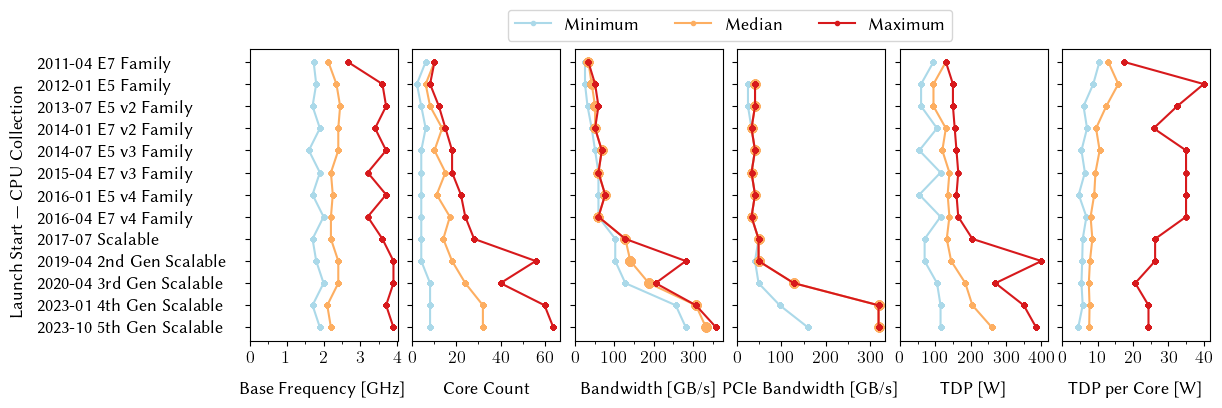

In [ ]:
figsize = (15, 4)
fontsize = 13

# Min / Max core count per collection
df_launch_year = df.groupby(key_collection)[key_launch_year_month].agg(['min', 'max'])
df_launch_year = df_launch_year.rename(columns={"min": "launch_min", "max": "launch_max"})

df_core_count = df.groupby(key_collection)[key_core_count].agg(['min', 'max', 'median'])
df_core_count = df_core_count.rename(columns={"min": "core_min", "max": "core_max", "median": "core_median"})

df_base_freq = df.groupby(key_collection)[key_base_freq].agg(['min', 'max', 'median'])
df_base_freq = df_base_freq.rename(columns={"min": "freq_min", "max": "freq_max", "median": "freq_median"})

df_tdp = df.groupby(key_collection)[key_tdp].agg(['min', 'max', 'median'])
df_tdp = df_tdp.rename(columns={"min": "tdp_min", "max": "tdp_max", "median": "tdp_median"})

df_tdp_per_core = df.groupby(key_collection)[key_tdp_per_core].agg(['min', 'max', 'median'])
df_tdp_per_core = df_tdp_per_core.rename(columns={"min": "tdp_core_min", "max": "tdp_core_max", "median": "tdp_core_median"})

df_bandwidth = df.groupby(key_collection)[key_bandwidth].agg(['min', 'max', 'median'])
df_bandwidth = df_bandwidth.rename(columns={"min": "bandwidth_min", "max": "bandwidth_max", "median": "bandwidth_median"})

df_pcie_bandwidth = df.groupby(key_collection)[key_pcie_bandwidth].agg(['min', 'max', 'median'])
df_pcie_bandwidth = df_pcie_bandwidth.rename(columns={"min": "pcie_bandwidth_min", "max": "pcie_bandwidth_max", "median": "pcie_bandwidth_median"})

plot_df = df_launch_year.join(df_core_count, on=key_collection)
plot_df = plot_df.join(df_base_freq, on=key_collection)
plot_df = plot_df.join(df_tdp, on=key_collection)
plot_df = plot_df.join(df_tdp_per_core, on=key_collection)
plot_df = plot_df.join(df_bandwidth, on=key_collection)
plot_df = plot_df.join(df_pcie_bandwidth, on=key_collection)
plot_df = plot_df.reset_index()
plot_df = pd.merge(plot_df, df[[key_collection, key_code_name]], on=key_collection, how='left')
plot_df['collection_short'] = plot_df[key_collection].str.replace(r'Processor(s?)(\s?)', '', regex=True)
plot_df['collection_short'] = plot_df['collection_short'].str.replace('Xeon ', '')
plot_df["year_collection"] = plot_df["launch_min"].astype(str) + " " + plot_df['collection_short']
plot_df = plot_df.sort_values(by='year_collection', ascending=False)

plt.close('all')
fig, axs = plt.subplots(1, 6, figsize=figsize, sharey=True, gridspec_kw = {'wspace':0.1})

# Adjust the subplot parameters to add space for the y-axis labels and legend
plt.subplots_adjust(left=0.31, right=0.95, top=0.88, bottom=0.15)

x_tick_label_rotation = 0
x_tick_label_pad = 10

plot_df.to_csv("../intel_cpus_plot.csv", header=True, index=False)

# Core Count
axs[1].plot(plot_df['core_min'], plot_df['year_collection'], marker='o', markersize=3, label='Minimum', color=colors_qualitative[0])
axs[1].plot(plot_df['core_median'], plot_df['year_collection'], marker='o', markersize=3, label='Median', color=colors_qualitative[1])
axs[1].plot(plot_df['core_max'], plot_df['year_collection'], marker='o', markersize=3, label='Maximum', color=colors_qualitative[2])
axs[1].set_xlabel('Core Count', fontsize=fontsize, labelpad=x_tick_label_pad)
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(20))
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(10))
axs[1].set_xlim(left=0)
axs[1].tick_params(axis='x', rotation=x_tick_label_rotation)

# Base Frequency
axs[0].plot(plot_df['freq_min'], plot_df['year_collection'], marker='o', markersize=3, label='Minimum', color=colors_qualitative[0])
axs[0].plot(plot_df['freq_median'], plot_df['year_collection'], marker='o', markersize=3, label='Median', color=colors_qualitative[1])
axs[0].plot(plot_df['freq_max'], plot_df['year_collection'], marker='o', markersize=3, label='Maximum', color=colors_qualitative[2])
axs[0].set_xlabel('Base Frequency [GHz]', fontsize=fontsize, labelpad=x_tick_label_pad)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
axs[0].set_xlim(left=0)
axs[0].tick_params(axis='x', rotation=x_tick_label_rotation)

# TDP
axs[4].plot(plot_df['tdp_min'], plot_df['year_collection'], marker='o', markersize=3, label='Minimum', color=colors_qualitative[0])
axs[4].plot(plot_df['tdp_median'], plot_df['year_collection'], marker='o', markersize=3, label='Median', color=colors_qualitative[1])
axs[4].plot(plot_df['tdp_max'], plot_df['year_collection'], marker='o', markersize=3, label='Maximum', color=colors_qualitative[2])
axs[4].set_xlabel('TDP [W]', fontsize=fontsize, labelpad=x_tick_label_pad)
axs[4].xaxis.set_major_locator(ticker.MultipleLocator(100))
axs[4].xaxis.set_minor_locator(ticker.MultipleLocator(50))
axs[4].set_xlim(left=0)
axs[4].tick_params(axis='x', rotation=x_tick_label_rotation)

# TDP per Core
axs[5].plot(plot_df['tdp_core_min'], plot_df['year_collection'], marker='o', markersize=3, label='Minimum', color=colors_qualitative[0])
axs[5].plot(plot_df['tdp_core_median'], plot_df['year_collection'], marker='o', markersize=3, label='Median', color=colors_qualitative[1])
axs[5].plot(plot_df['tdp_core_max'], plot_df['year_collection'], marker='o', markersize=3, label='Maximum', color=colors_qualitative[2])
axs[5].set_xlabel('TDP per Core [W]', fontsize=fontsize, labelpad=x_tick_label_pad)
axs[5].xaxis.set_major_locator(ticker.MultipleLocator(10))
axs[5].xaxis.set_minor_locator(ticker.MultipleLocator(5))
axs[5].set_xlim(left=0)
axs[5].tick_params(axis='x', rotation=x_tick_label_rotation)

# Bandwidth
axs[2].plot(plot_df['bandwidth_min'], plot_df['year_collection'], marker='o', markersize=3, label='Minimum', color=colors_qualitative[0])
axs[2].plot(plot_df['bandwidth_median'], plot_df['year_collection'], marker='o', label='Median', color=colors_qualitative[1])
axs[2].plot(plot_df['bandwidth_max'], plot_df['year_collection'], marker='o', markersize=3, label='Maximum', color=colors_qualitative[2])
#axs[2].axhline(y=9)
#axs[2].axhline(y=2)
#axs[2].text(300, 9 + 0.25, 'DDR4')
#axs[2].text(300, 2 + 0.25, 'DDR5')
axs[2].set_xlabel('Bandwidth [GB/s]', fontsize=fontsize, labelpad=x_tick_label_pad)
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(100))
axs[2].xaxis.set_minor_locator(ticker.MultipleLocator(50))
axs[2].set_xlim(left=0)
axs[2].tick_params(axis='x', rotation=x_tick_label_rotation)

# PCIe Bandwidth
axs[3].plot(plot_df['pcie_bandwidth_min'], plot_df['year_collection'], marker='o', markersize=3, label='Minimum', color=colors_qualitative[0])
axs[3].plot(plot_df['pcie_bandwidth_median'], plot_df['year_collection'], marker='o', label='Median', color=colors_qualitative[1])
axs[3].plot(plot_df['pcie_bandwidth_max'], plot_df['year_collection'], marker='o', markersize=3, label='Maximum', color=colors_qualitative[2])
axs[3].set_xlabel('PCIe Bandwidth [GB/s]', fontsize=fontsize, labelpad=x_tick_label_pad)
axs[3].xaxis.set_major_locator(ticker.MultipleLocator(100))
axs[3].xaxis.set_minor_locator(ticker.MultipleLocator(50))
axs[3].set_xlim(left=0)
axs[3].tick_params(axis='x', rotation=x_tick_label_rotation)

# Adjust y-axis label position
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.yaxis.set_tick_params(pad=150)  # Adjust the padding for better alignment
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')

# Add a shared legend above the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.63, 1.0), ncol=3, fontsize=fontsize)

fig.supylabel('Launch Start | CPU Collection', fontsize=fontsize, x=0.15)
fig.tight_layout()
fig.savefig("../figures/intel_xeon_evolution.pdf", bbox_inches='tight')
fig.savefig("../figures/intel_xeon_evolution.svg", bbox_inches='tight')
plt.show()


/var/folders/z4/3bk11y114tn3lh60qlpnzh6m0000gn/T/ipykernel_99463/3443258814.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


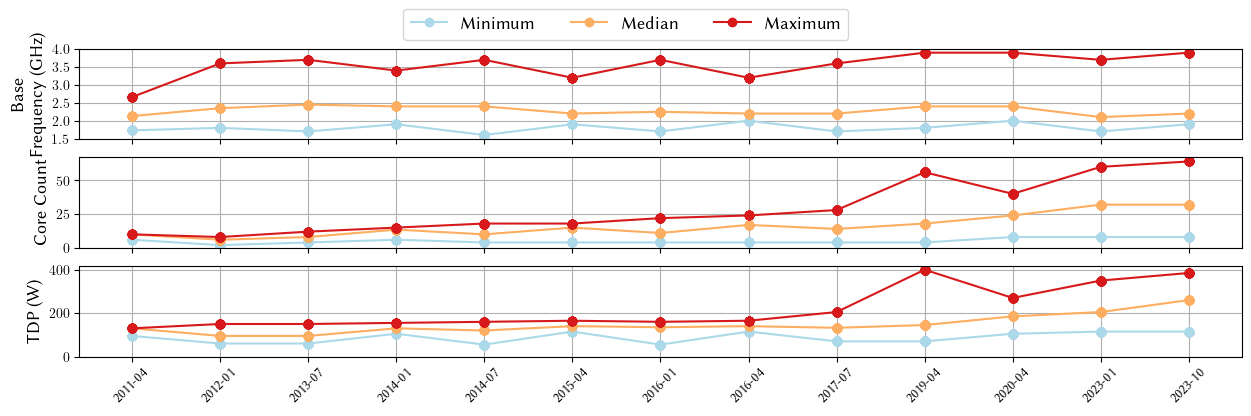

In [ ]:
figsize = (15, 4)
fontsize = 13

# Min / Max core count per collection
df_launch_year = df.groupby(key_collection)[key_launch_year_month].agg(['min', 'max'])
df_launch_year = df_launch_year.rename(columns={"min": "launch_min", "max": "launch_max"})

df_core_count = df.groupby(key_collection)[key_core_count].agg(['min', 'max', 'median'])
df_core_count = df_core_count.rename(columns={"min": "core_min", "max": "core_max", "median": "core_median"})

df_base_freq = df.groupby(key_collection)[key_base_freq].agg(['min', 'max', 'median'])
df_base_freq = df_base_freq.rename(columns={"min": "freq_min", "max": "freq_max", "median": "freq_median"})

df_tdp = df.groupby(key_collection)[key_tdp].agg(['min', 'max', 'median'])
df_tdp = df_tdp.rename(columns={"min": "tdp_min", "max": "tdp_max", "median": "tdp_median"})

df_tdp_per_core = df.groupby(key_collection)[key_tdp_per_core].agg(['min', 'max', 'median'])
df_tdp_per_core = df_tdp_per_core.rename(columns={"min": "tdp_core_min", "max": "tdp_core_max", "median": "tdp_core_median"})

plot_df = df_launch_year.join(df_core_count, on=key_collection)
plot_df = plot_df.join(df_base_freq, on=key_collection)
plot_df = plot_df.join(df_tdp, on=key_collection)
plot_df = plot_df.join(df_tdp_per_core, on=key_collection)
plot_df = plot_df.reset_index()
plot_df = pd.merge(plot_df, df[[key_collection, key_code_name]], on=key_collection, how='left')
plot_df["year_collection"] = plot_df["launch_min"].astype(str) + " | " + plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection', ascending=False)
plot_df = plot_df.sort_values(by='launch_min', ascending=True)

plt.close('all')
fig, axs = plt.subplots(3, 1, figsize=figsize, gridspec_kw = {'wspace':0.08})

# Adjust the subplot parameters to add space for the y-axis labels and legend
# plt.subplots_adjust(left=0.31, right=0.95, top=0.88, bottom=0.15)

# Base Frequency
axs[0].plot(plot_df['launch_min'], plot_df['freq_min'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[0].plot(plot_df['launch_min'], plot_df['freq_median'], marker='o', label='Median', color=colors_qualitative[1])
axs[0].plot(plot_df['launch_min'], plot_df['freq_max'], marker='o', label='Maximum', color=colors_qualitative[2])
axs[0].set_ylabel('Base \nFrequency (GHz)', fontsize=fontsize)
axs[0].grid(True)
axs[0].set_xticklabels([])
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))

axs[1].plot(plot_df['launch_min'], plot_df['core_min'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[1].plot(plot_df['launch_min'], plot_df['core_median'], marker='o', label='Median', color=colors_qualitative[1])
axs[1].plot(plot_df['launch_min'], plot_df['core_max'], marker='o', label='Maximum', color=colors_qualitative[2])
axs[1].set_ylabel('Core Count', fontsize=fontsize)
axs[1].grid(True)
axs[1].set_xticklabels([])
axs[1].set_ylim(0)

axs[2].plot(plot_df['launch_min'], plot_df['tdp_min'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[2].plot(plot_df['launch_min'], plot_df['tdp_median'], marker='o', label='Median', color=colors_qualitative[1])
axs[2].plot(plot_df['launch_min'], plot_df['tdp_max'], marker='o', label='Maximum', color=colors_qualitative[2])
axs[2].set_ylabel('TDP (W)', fontsize=fontsize)
axs[2].grid(True)
axs[2].set_ylim(0)

axs[-1].tick_params(axis='x', rotation=45)

# Add a shared legend above the subplots
handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.63, 1.07), ncol=3, fontsize=fontsize)
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=fontsize)

# fig.supylabel('Launch Start | CPU Collection', fontsize=fontsize, x=0.015)
fig.tight_layout()
fig.savefig("../figures/intel_xeon_evolution.pdf", bbox_inches='tight')
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\#'
<>:38: SyntaxWarning: invalid escape sequence '\#'
<>:48: SyntaxWarning: invalid escape sequence '\#'
<>:49: SyntaxWarning: invalid escape sequence '\#'
<>:37: SyntaxWarning: invalid escape sequence '\#'
<>:38: SyntaxWarning: invalid escape sequence '\#'
<>:48: SyntaxWarning: invalid escape sequence '\#'
<>:49: SyntaxWarning: invalid escape sequence '\#'
/var/folders/z4/3bk11y114tn3lh60qlpnzh6m0000gn/T/ipykernel_99463/1827778335.py:37: SyntaxWarning: invalid escape sequence '\#'
  axs[0].set_xlabel('\# Memory Channels', fontsize=fontsize)
/var/folders/z4/3bk11y114tn3lh60qlpnzh6m0000gn/T/ipykernel_99463/1827778335.py:38: SyntaxWarning: invalid escape sequence '\#'
  axs[0].set_title('\# Memory Channels', fontsize=fontsize)
/var/folders/z4/3bk11y114tn3lh60qlpnzh6m0000gn/T/ipykernel_99463/1827778335.py:48: SyntaxWarning: invalid escape sequence '\#'
  axs[1].set_xlabel('\# PCIe Lanes', fontsize=fontsize)
/var/folders/z4/3bk11y114tn3lh60ql

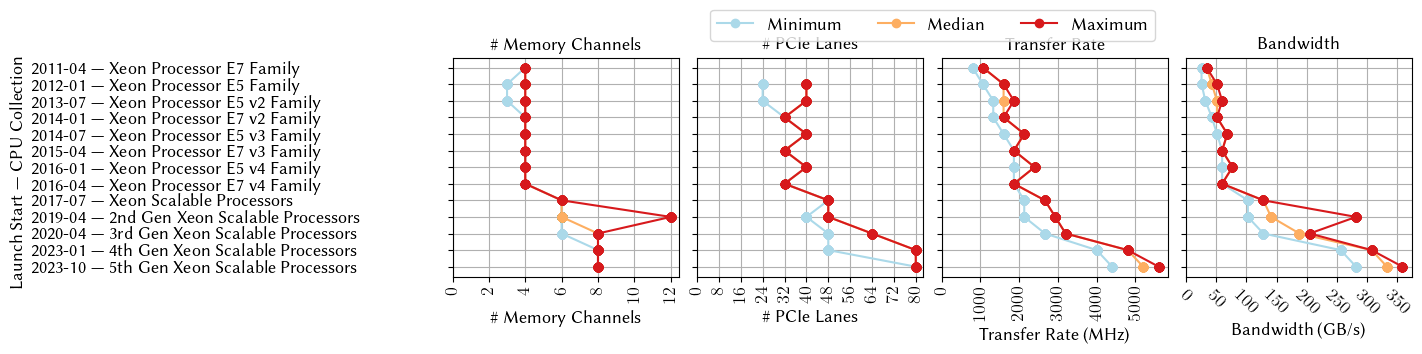

In [ ]:
figsize = (15, 3)
fontsize = 13

df_max_dimms = df.groupby(key_collection)[key_max_memory_channels].agg(['min', 'max', 'median'])
df_max_dimms = df_max_dimms.rename(columns={"min": "max_dimms_min", "max": "max_dimms_max", "median": "max_dimms_median"})

df_max_pcie_lanes = df.groupby(key_collection)[key_max_pcie_lanes].agg(['min', 'max', 'median'])
df_max_pcie_lanes = df_max_pcie_lanes.rename(columns={"min": "max_pcie_lanes_min", "max": "max_pcie_lanes_max", "median": "max_pcie_lanes_median"})

df_max_transfer_rate = df
df_max_transfer_rate[key_max_transfer_rate] = pd.to_numeric(df_max_transfer_rate[key_max_transfer_rate], errors='coerce')
df_max_transfer_rate = df_max_transfer_rate.groupby(key_collection)[key_max_transfer_rate].agg(['min', 'max', 'median'])
df_max_transfer_rate = df_max_transfer_rate.rename(columns={"min": "max_transfer_rate_min", "max": "max_transfer_rate_max", "median": "max_transfer_rate_median"})

df_bandwidth = df.groupby(key_collection)[key_bandwidth].agg(['min', 'max', 'median'])
df_bandwidth = df_bandwidth.rename(columns={"min": "bandwidth_min", "max": "bandwidth_max", "median": "bandwidth_median"})

plot_df = df_launch_year.join(df_max_dimms, on=key_collection)
plot_df = plot_df.join(df_max_pcie_lanes, on=key_collection)
plot_df = plot_df.join(df_max_transfer_rate, on=key_collection)
plot_df = plot_df.join(df_bandwidth, on=key_collection)
plot_df = plot_df.reset_index()
plot_df = pd.merge(plot_df, df[[key_collection, key_code_name]], on=key_collection, how='left')
plot_df["year_collection"] = plot_df["launch_min"].astype(str) + " | " + plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection', ascending=False)

plt.close('all')
fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True, gridspec_kw = {'wspace':0.08})

# Adjust the subplot parameters to add space for the y-axis labels and legend
plt.subplots_adjust(left=0.31, right=0.95, top=0.88, bottom=0.15)

# Max # of Memory Channels
axs[0].plot(plot_df['max_dimms_min'], plot_df['year_collection'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[0].plot(plot_df['max_dimms_median'], plot_df['year_collection'], marker='o', label='Median', color=colors_qualitative[1])
axs[0].plot(plot_df['max_dimms_max'], plot_df['year_collection'], marker='o', label='Maximum', color=colors_qualitative[2])
axs[0].set_xlabel('\# Memory Channels', fontsize=fontsize)
axs[0].set_title('\# Memory Channels', fontsize=fontsize)
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(2))
axs[0].set_xlim(left=0)
axs[0].tick_params(axis='x', rotation=90)

# Max # of PCI Express Lanes
axs[1].plot(plot_df['max_pcie_lanes_min'], plot_df['year_collection'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[1].plot(plot_df['max_pcie_lanes_median'], plot_df['year_collection'], marker='o', label='Median', color=colors_qualitative[1])
axs[1].plot(plot_df['max_pcie_lanes_max'], plot_df['year_collection'], marker='o', label='Maximum', color=colors_qualitative[2])
axs[1].set_xlabel('\# PCIe Lanes', fontsize=fontsize)
axs[1].set_title('\# PCIe Lanes', fontsize=fontsize)
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(8))
axs[1].set_xlim(left=0)
axs[1].tick_params(axis='x', rotation=90)

# Transfer Rate
axs[2].plot(plot_df['max_transfer_rate_min'], plot_df['year_collection'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[2].plot(plot_df['max_transfer_rate_median'], plot_df['year_collection'], marker='o', label='Median', color=colors_qualitative[1])
axs[2].plot(plot_df['max_transfer_rate_max'], plot_df['year_collection'], marker='o', label='Maximum', color=colors_qualitative[2])
axs[2].set_xlabel('Transfer Rate (MHz)', fontsize=fontsize)
axs[2].set_title('Transfer Rate', fontsize=fontsize)
axs[2].grid(True)
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1000))
axs[2].set_xlim(left=0)
axs[2].tick_params(axis='x', rotation=90)

# Bandwidth
axs[3].plot(plot_df['bandwidth_min'], plot_df['year_collection'], marker='o', label='Minimum', color=colors_qualitative[0])
axs[3].plot(plot_df['bandwidth_median'], plot_df['year_collection'], marker='o', label='Median', color=colors_qualitative[1])
axs[3].plot(plot_df['bandwidth_max'], plot_df['year_collection'], marker='o', label='Maximum', color=colors_qualitative[2])
#axs[3].axhline(y=9)
#axs[3].axhline(y=2)
#axs[3].text(300, 9 + 0.25, 'DDR4')
#axs[3].text(300, 2 + 0.25, 'DDR5')
axs[3].set_xlabel('Bandwidth (GB/s)', fontsize=fontsize)
axs[3].set_title('Bandwidth', fontsize=fontsize)
axs[3].xaxis.set_major_locator(ticker.MultipleLocator(50))
axs[3].set_xlim(left=0)
axs[3].tick_params(axis='x', rotation=-45)
axs[3].grid(True)

# Adjust y-axis label position
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.yaxis.set_tick_params(pad=300)  # Adjust the padding for better alignment
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')

# Add a shared legend above the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.63, 1.07), ncol=3, fontsize=fontsize)

fig.supylabel('Launch Start | CPU Collection', fontsize=fontsize, x=0.015)
fig.tight_layout()
fig.savefig("../figures/intel_xeon_memory_evolution.pdf", bbox_inches='tight')
plt.show()

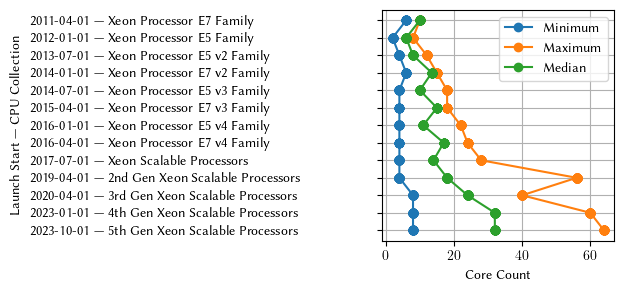

In [ ]:
figsize = (3,3)

y_labelpad = 5

# Min / Max cour count per collection
df_launch_year = df.groupby(key_collection)[key_launch_date].agg(['min','max'])
df_launch_year = df_launch_year.rename(columns={"min":"launch_min", "max":"launch_max"})
df_core_count = df.groupby(key_collection)[key_core_count].agg(['min','max','median'])
df_core_count = df_core_count.rename(columns={"min":"core_min", "max":"core_max", "median":"core_median"})
plot_df = df_launch_year.join(df_core_count, on=key_collection)
plot_df = plot_df.reset_index()
plot_df = pd.merge(plot_df, df[[key_collection, key_code_name]], on=key_collection, how='left')
# plot_df = plot_df.join(df[[key_code_name]].drop_duplicates(), on=key_collection, how='left')
# Add this if you want to differentiate between microarchitectures in the different collections.
# plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection] + " | " + plot_df[key_code_name]
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

# print(df[key_collection].unique())

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['core_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['core_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['core_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('Core Count')
plt.ylabel('Launch Start | CPU Collection', labelpad=y_labelpad)
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

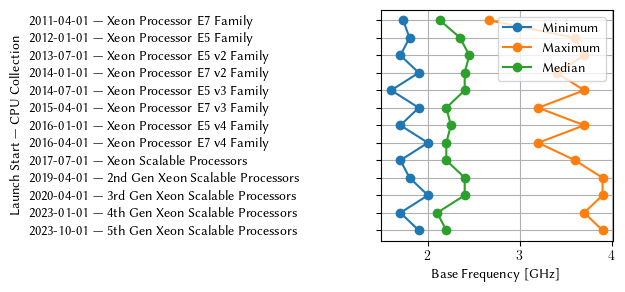

In [ ]:
# Min / Max cour count per collection
df_base_frequency = df.groupby(key_collection)[key_base_freq].agg(['min','max','median'])
df_base_frequency = df_base_frequency.rename(columns={"min":"base_freq_min", "max":"base_freq_max", "median":"base_freq_median"})
# print(df_base_frequency)
plot_df = df_launch_year.join(df_base_frequency, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['base_freq_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['base_freq_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['base_freq_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('Base Frequency [GHz]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

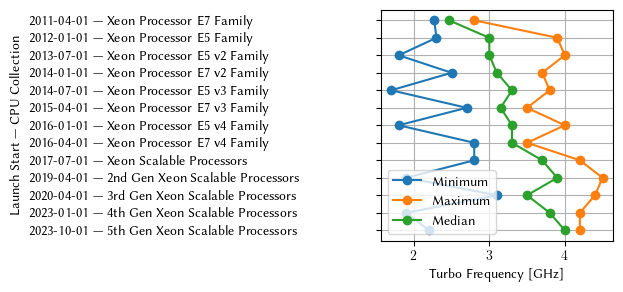

In [ ]:
# Frequency
df_frequency = df.groupby(key_collection)[key_turbo_freq].agg(['min','max','median'])
df_frequency = df_frequency.rename(columns={"min":"freq_min", "max":"freq_max", "median":"freq_median"})
# print(df_frequency)
plot_df = df_launch_year.join(df_frequency, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['freq_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['freq_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['freq_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('Turbo Frequency [GHz]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

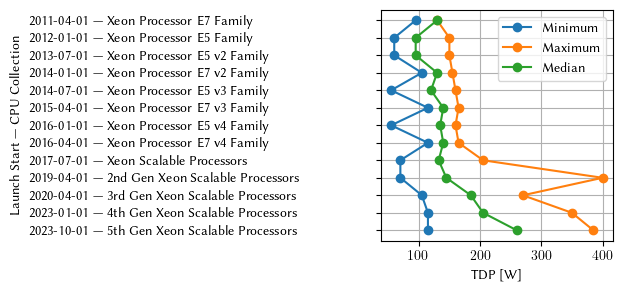

In [ ]:
# TDP
df_tdp = df.groupby(key_collection)[key_tdp].agg(['min','max','median'])
df_tdp = df_tdp.rename(columns={"min":"tdp_min", "max":"tdp_max", "median":"tdp_median"})
# print(df_tdp)
plot_df = df_launch_year.join(df_tdp, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['tdp_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['tdp_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['tdp_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('TDP [W]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

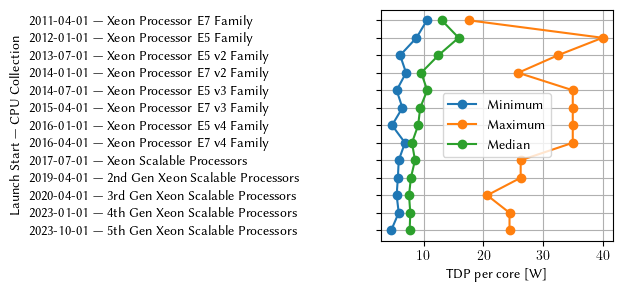

In [ ]:
# TDP per core
df_tdp = df.groupby(key_collection)[key_tdp_per_core].agg(['min','max','median'])
df_tdp = df_tdp.rename(columns={"min":"tdp_min", "max":"tdp_max", "median":"tdp_median"})
# print(df_tdp)
plot_df = df_launch_year.join(df_tdp, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['tdp_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['tdp_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['tdp_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('TDP per core [W]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

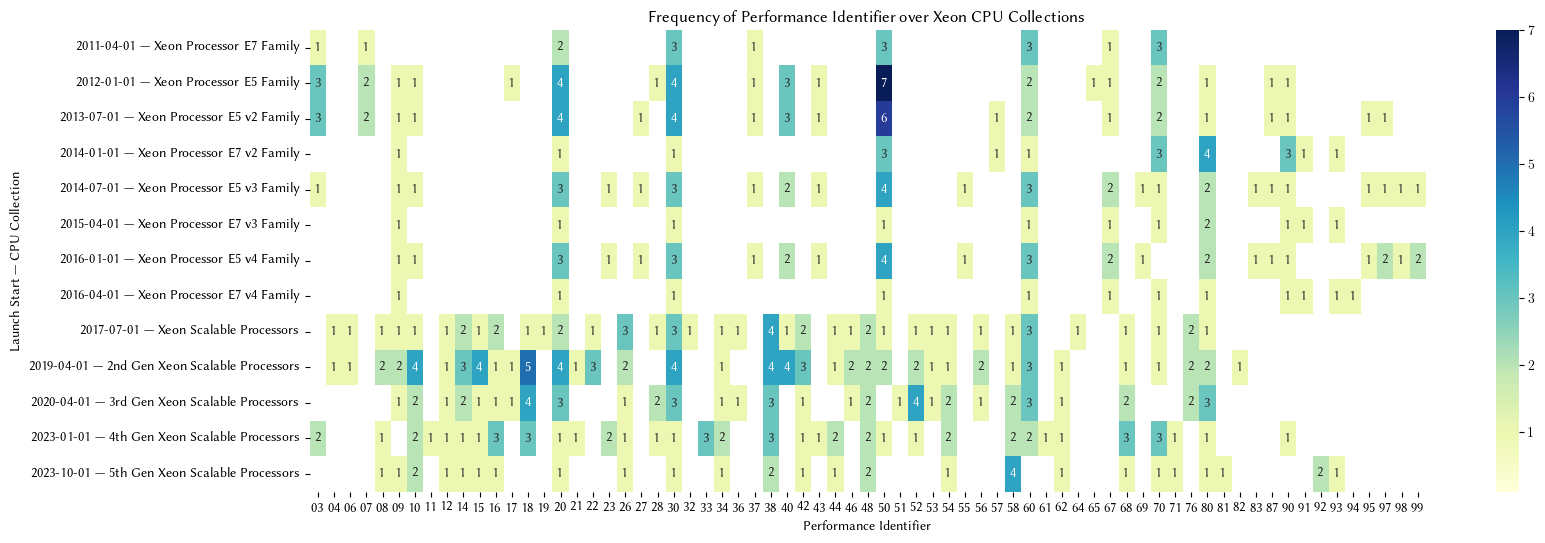

In [ ]:
# df_launch_year = df_launch_year.reset_index()
df_plot = pd.merge(df, df_launch_year, on=key_collection, how='left')
df_plot["year_collection"] = df_plot["launch_min"] + " | " + df_plot[key_collection]

# Create a pivot table to count occurrences
pivot_table = df_plot.pivot_table(index="year_collection", columns=key_perf_id, aggfunc='size', fill_value=0)

# Define a custom color map
cmap = sns.color_palette("YlGnBu", as_cmap=True)
cmap.set_under('white')

# Plotting the heatmap
plt.figure(figsize=(18, 6))
ax = sns.heatmap(pivot_table, annot=True, fmt="d", cmap=cmap, cbar=True, mask=(pivot_table == 0), vmin=0.1)

# Set the x-axis labels to show all columns
ax.set_xticks([tick + 0.5 for tick in range(len(pivot_table.columns))])  # Center the ticks
ax.set_xticklabels(pivot_table.columns)

plt.title('Frequency of Performance Identifier over Xeon CPU Collections')
plt.xlabel('Performance Identifier')
plt.ylabel('Launch Start | CPU Collection')
plt.show()